# Develop `wave_height_period` Figure Module

Development of functions for `nowcast.figures.wwatch3.wave_height_period` web site figure module.

In [1]:
from pathlib import Path
from types import SimpleNamespace

import matplotlib.dates
import matplotlib.pyplot as plt
import requests
import xarray
from salishsea_tools.places import PLACES

from nowcast.figures import shared
import nowcast.figures.website_theme

In [2]:
%matplotlib inline

## `_get_wwatch3_fields()` Function

In [3]:
def _get_wwatch3_fields(dataset_url):
    ## TODO: This is a work-around because neither netCDF4 nor xarray are able
    ## to load the dataset directly from the URL due to an OpenDAP issue
    dataset_id = dataset_url.rsplit('/', 1)[1].split('.', 1)[0]
    wwatch3_fields_file = Path('/tmp').joinpath(dataset_id).with_suffix('.nc')
    with wwatch3_fields_file.open('wb') as f:
        resp = requests.get(f'{dataset_url}')
        f.write(resp.content)
    try:
        wwatch3_fields = xarray.open_dataset(wwatch3_fields_file)
    except OSError:
        raise ValueError(f'WaveWatch3 fields dataset not found')
    return wwatch3_fields

## `_prep_plot_data()` Function

In [129]:
def _prep_plot_data(buoy, wwatch3_dataset_url):
    wwatch3_fields = _get_wwatch3_fields(wwatch3_dataset_url)
    wwatch3 = xarray.Dataset({
        'wave_height': wwatch3_fields.hs.sel(
            longitude=PLACES[buoy]['lon lat'][0]+360,
            latitude=PLACES[buoy]['lon lat'][1],
            method='nearest',
        ),
        'peak_freq': wwatch3_fields.fp.sel(
            longitude=PLACES[buoy]['lon lat'][0]+360,
            latitude=PLACES[buoy]['lon lat'][1],
            method='nearest',
        ),
    })
    wwatch3_period = slice(
        str(wwatch3_fields.time.values[0]), str(wwatch3_fields.time.values[-1])
    )
    obs = get_ndbc_buoy(buoy)
    obs = xarray.Dataset({
        'wave_height': obs.loc[wwatch3_period, 'WVHT [m]'],
        'dominant_period': obs.loc[wwatch3_period, 'DPD [sec]'],
    })
    # Change dataset times to Pacific time zone
    shared.localize_time(wwatch3)
    shared.localize_time(obs)
    return SimpleNamespace(
        wwatch3=wwatch3,
        obs=obs,
    )

## `_prep_fig_axes() Function`

In [5]:
def _prep_fig_axes(figsize, theme):
    fig, (ax_sig_height, ax_peak_freq) = plt.subplots(
        2, 1, figsize=figsize, facecolor=theme.COLOURS['figure']['facecolor']
    )
    fig.autofmt_xdate()
    return fig, (ax_sig_height, ax_peak_freq)


## `_plot_wave_height_time_series()` Function

In [125]:
def _plot_wave_height_time_series(ax, place, plot_data, theme):
    plot_data.obs.wave_height.plot(
        ax=ax,
        linewidth=2,
        label='ECCC Observed',
        color=theme.COLOURS['time series']['obs wave height'],
    )
    plot_data.wwatch3.wave_height.plot(
        ax=ax,
        linewidth=2,
        label='WaveWatch3',
        color=theme.COLOURS['time series']['wave height'],
    )
    legend = ax.legend(prop=theme.FONTS['legend label small'])
    legend.set_title('Legend', prop=theme.FONTS['legend title small'])
    _wave_height_time_series_labels(ax, place, plot_data, theme)

## `_wave_height_time_series_labels()` Function

In [126]:
def _wave_height_time_series_labels(ax, place, plot_data, theme):
    ax.set_title(
        f'Significant Wave Height at {place}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax.set_ylabel(
        'Significant Wave Height [m]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.grid(axis='both')
    theme.set_axis_colors(ax)

## `_plot_dominant_period_time_series()` Function

In [127]:
def _plot_dominant_period_time_series(ax, place, plot_data, theme):
    plot_data.obs.dominant_period.plot(
        ax=ax,
        linewidth=2,
        label='ECCC Observed',
        color=theme.COLOURS['time series']['obs wave period'],
    )
    (1/plot_data.wwatch3.peak_freq).plot(
        ax=ax,
        linewidth=2,
        label='WaveWatch3',
        color=theme.COLOURS['time series']['wave period'],
    )
    legend = ax.legend(prop=theme.FONTS['legend label small'])
    legend.set_title('Legend', prop=theme.FONTS['legend title small'])
    _dominant_period_time_series_labels(ax, place, plot_data, theme)

## `_dominant_period_time_series_labels()` Function

In [121]:
def _dominant_period_time_series_labels(ax, place, plot_data, theme):
    ax.set_title(
        f'Dominant Wave Period at {place}',
        fontproperties=theme.FONTS['axes title'],
        color=theme.COLOURS['text']['axes title']
    )
    ax.set_xlabel(
        f'Time [{plot_data.wwatch3.attrs["tz_name"]}]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%d%b %H:%M'))
    ax.set_ylabel(
        'Dominant Wave Period [s]',
        fontproperties=theme.FONTS['axis'],
        color=theme.COLOURS['text']['axis']
    )
    ax.grid(axis='both')
    theme.set_axis_colors(ax)

## `make_figure()` Function

This is is the function that will be called by the `nowcast.workers.make_plots` worker to return a `matplotlib.figure.Figure` object.

In [114]:
def make_figure(
    buoy,
    wwatch3_dataset_url,
    figsize=(16, 9),
    theme=nowcast.figures.website_theme,
):
    plot_data = _prep_plot_data(buoy, wwatch3_dataset_url)
    fig, (ax_sig_height, ax_peak_freq) = _prep_fig_axes(figsize, theme)
    _plot_wave_height_time_series(ax_sig_height, buoy, plot_data, theme)
    _plot_dominant_period_time_series(ax_peak_freq, buoy, plot_data, theme)
    return fig

## Render the Figure

The `%%timeit` cell magic lets us keep an eye on how log the figure takes to process.
Setting `-n1 -r1` prevents it from processing the figure more than once
as it might try to do to generate better statistics.

2.79 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


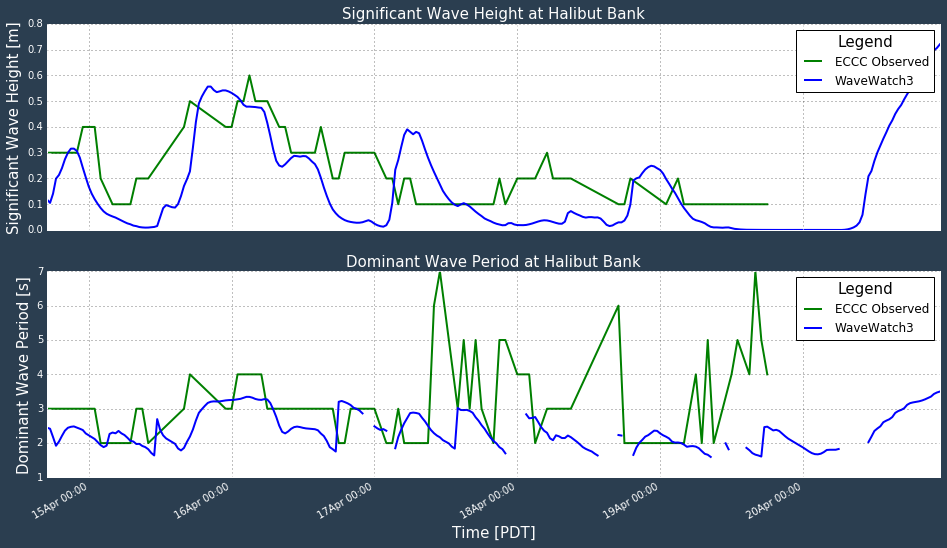

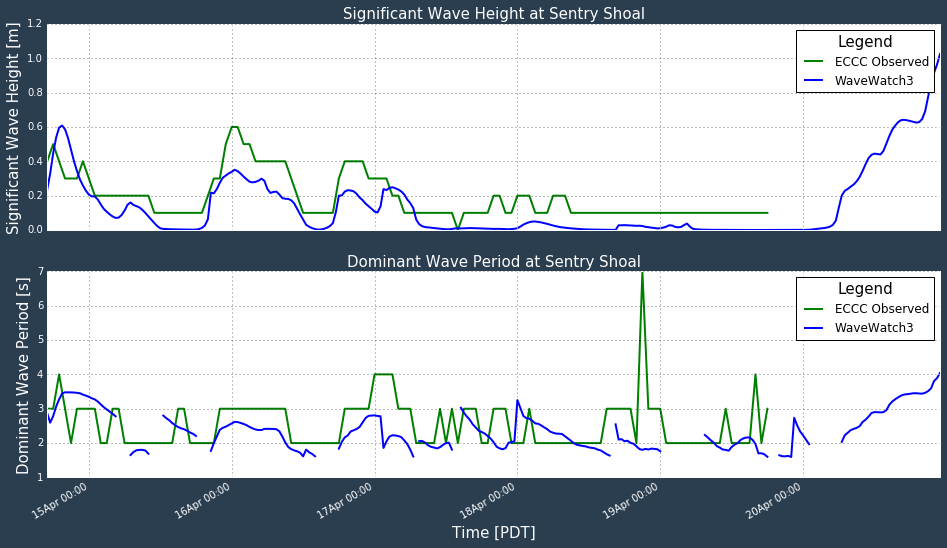

In [130]:
%%timeit -n1 -r1

from importlib import reload
from nowcast.figures import website_theme
from salishsea_tools import places
reload(website_theme)
reload(places)

wwatch3_dataset_url = (
    'https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSf2DWaveFields30mV17-02.nc?hs,fp'
)

fig = make_figure('Halibut Bank', wwatch3_dataset_url)
fig = make_figure('Sentry Shoal', wwatch3_dataset_url)